# Coursera Capstone Project - Battle of the Neighbourhood
## Hongfang Lu

This project will utilize Foursquare api to create visualization, do machine learning analysis.

London Moscow New York

In [1]:
import pandas as pd
import scipy
import numpy as np
import folium
import requests
import re
import os
import pickle

from tqdm import tqdm
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim #convert address to latitude and longitude
from geopy import distance as ll_distance

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


## 1. Get London neighbourhoods information

Get the list of areas in London through wikipedia page

In [2]:
page_london = requests.get('https://en.wikipedia.org/wiki/List_of_areas_of_London')
page_london

<Response [200]>

Using Beautiful Soup to find the table that contains the neighbourhoods information

In [3]:
soup = BeautifulSoup(page_london.content, 'html.parser')
tables = soup.find_all('table', {'class': 'wikitable'})

Get the columns of the table, then remove all space (or unicode non-breaking sign), replace them with underscores

In [4]:
columns_row = tables[0].tbody.contents[0].children
columns_name = []
for co in columns_row:
    if co != '\n':
        #print(co.text)
        columns_name.append(co.text)

columns_name = map(lambda x: x.replace(u'\xa0', '_')
                   .replace(' ', '_').strip() 
                   if isinstance(x, (str, bytes)) 
                   else x, columns_name)

Get the columns names

In [5]:
columns_name = list(columns_name)
print(columns_name)

['Location', 'London_borough', 'Post_town', 'Postcode_district', 'Dial_code', 'OS_grid_ref']


Get the rows for each neighbourhood from the parsed webpage

In [6]:
locations = tables[0].tbody.contents[1:]

try:
    with open('london_raw.pkl', 'rb') as infile:
        all_data = pickle.load(infile)
        print('london raw data is loaded.')
except:
    all_data = []
    for location in tqdm(locations):
        if location != '\n':
            #print(location)
            loc_data = []
            for co in location:
                if co != '\n':
                    #print(co.contents[0])
                    try: 
                        urll = co.contents[0]['href']
                        loc_data.append(urll)
                        loc_data.append(co.text.strip())
                    except:
                        loc_data.append(co.text.strip())
            all_data.append(loc_data)
    
    with open('london_raw.pkl', 'wb') as outfile:
        pickle.dump(all_data, outfile)
        print('london raw data is scraped and saved.')

london raw data is loaded.


In [7]:
len(all_data)

533

These two utility functions transforms the coordinates to decimal.

the function `process_lan_lat()` transforms the coordinates from the form of '1.23N, 0.33W' into a list of the latitudes and longitudes, in the form of \[1.23, -0.33\]. 
the function `lat_long_to_dec()` transforms the coordinates from the form of """  37°12'12"S 122°45'23"W   """ into a list of the latitudes and longitudes, in the form of \[37.2033, 12.756389\]. The difference lies in whether to take care of the degree (°), minute ('), and second (") symbol.

In [8]:
def process_lan_lat(strn):
    strn = strn.strip()
    N_sign = True
    E_sign = True
    
    lat_p = strn.find('N')
    if lat_p == -1:
        N_sign = False
        lat_p = strn.find('S')
    
    lon_p = strn.find('E')
    if lon_p == -1:
        E_sign = False
        lon_p = strn.find('W')
    
    lat = strn[:(lat_p - 1)]
    lon = strn[(lat_p + 2):(lon_p - 1)]
    
    lat_sign = 1.0 if N_sign else -1.0
    lon_sign = 1.0 if E_sign else -1.0
    return [float(lat) * lat_sign, float(lon) * lon_sign]


def lat_long_to_dec(strn):
    strn = strn.strip()
    restemp = re.split('[°\'"′″ ]+', strn)
    
    #print(restemp)
    
    N_sign = 'N' in restemp
    E_sign = 'E' in restemp
    
    #print([N_sign, E_sign])
    
    if N_sign:
        lat_p = restemp.index('N')
    else:
        lat_p = restemp.index('S')
    
    if E_sign:
        lon_p = restemp.index('E')
    else:
        lon_p = restemp.index('W')
    
    #print([lat_p, lon_p])
    
    if lat_p == 1:
        lat = float(restemp[0])
    elif lat_p == 2:
        lat = float(restemp[0]) + float(restemp[1]) / 60
    elif lat_p == 3:
        lat = float(restemp[0]) + float(restemp[1]) / 60 + \
            float(restemp[2]) / 3600
    else:
        raise Exception('Wrong latitude format.')
    
    if (lon_p - lat_p) == 2:
        lon = float(restemp[lat_p + 1])
    elif (lon_p - lat_p) == 3:
        lon = float(restemp[lat_p + 1]) + float(restemp[lat_p + 2]) / 60
    elif (lon_p - lat_p) == 4:
        lon = float(restemp[lat_p + 1]) + float(restemp[lat_p + 2]) / 60 + \
            float(restemp[lat_p + 3]) / 3600
    else:
        raise Exception('Wrong longitude format.')
    
    #print([lat, lon])
    
    lat_sign = 1.0 if N_sign else -1.0
    lon_sign = 1.0 if E_sign else -1.0
    return [float(lat) * lat_sign, float(lon) * lon_sign]

Parse wikipedia pages of each neighbourhood, then get the geograpical coordinate

In [9]:
%%time

try:
    with open('lat_lon_london.pkl', 'rb') as infile:
        lat_lon_all = pickle.load(infile)
        print('london lat lon is loaded.')
except:
    lat_lon_all = [None for i in range(len(all_data))]

    for i in tqdm(range(len(all_data))):
        urll = 'https://en.wikipedia.org' + all_data[i][0]
        page = requests.get(urll)

        soup = BeautifulSoup(page.content, 'html.parser')

        lls = soup.find_all('span', {'class': 'geo-dec'})
        if len(lls) > 0:
            #print(all_data[i][1])
            #print(lls[0].text)

            lat_lon_all[i] = str(lls[0].text)
    
    with open('lat_lon_london.pkl', 'wb') as outfile:
        pickle.dump(lat_lon_all, outfile)
        print('london lat lon is scraped and saved.')


london lat lon is loaded.
Wall time: 3 ms


Transform the geographical coordinates into lists

In [10]:
%%time
for i in range(len(all_data)):
    if lat_lon_all[i]:
        lat_lon = process_lan_lat(lat_lon_all[i])
    else:
        lat_lon = [None, None]
    
    all_data[i].extend(lat_lon)

Wall time: 4 ms


Create the dataframe.

In [11]:
london_df = pd.DataFrame(all_data, columns=['Link'] + columns_name + ['Latitude', 'Longitude'])
london_df.head()

,Link,Location,London_borough,Post_town,Postcode_district,Dial_code,OS_grid_ref,Latitude,Longitude
0,/wiki/Abbey_Wood,Abbey Wood,"Bexley, Greenwich [1]",LONDON,SE2,020,TQ465785,51.486400,0.110900
1,"/wiki/Acton,_London",Acton,"Ealing, Hammersmith and Fulham[2]",LONDON,"W3, W4",020,TQ205805,51.513519,-0.270661
2,"/wiki/Addington,_London",Addington,Croydon[2],CROYDON,CR0,020,TQ375645,51.358300,-0.030500
3,/wiki/Addiscombe,Addiscombe,Croydon[2],CROYDON,CR0,020,TQ345665,51.381000,-0.066300
4,"/wiki/Albany_Park,_Bexley",Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728,51.426400,0.102600


There are some rows that don't have the latitude/longitude information, which is line 109 and 355.

In [12]:
london_df[london_df['Latitude'].isnull()]

,Link,Location,London_borough,Post_town,Postcode_district,Dial_code,OS_grid_ref,Latitude,Longitude
109,/wiki/Colyers_(ward),Colyers,Bexley,ERITH,DA8,01322,TQ512768,NaN,NaN
355,/wiki/Oval,Oval,Lambeth,LONDON,"SW8, SW9, SE11",020,TQ315575,NaN,NaN


Remove the rows with NaN values.

In [13]:
london_df.dropna(axis=0, inplace=True)

In [14]:
london_df.shape

(531, 9)

In [15]:
address = 'London, England'

geolocator = Nominatim(user_agent="ld_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

london_lon_lat = [latitude, longitude]

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [16]:
london = folium.Map(location=london_lon_lat, zoom_start=11, control_scale=True)

for lat, lng, borough, neighborhood in zip(london_df['Latitude'], \
                                           london_df['Longitude'], \
                                           london_df['London_borough'], \
                                           london_df['Location']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(london)  
    
london

## 2. Get Moscow information

In [17]:
page_mos = requests.get('https://en.wikipedia.org/wiki/Administrative_divisions_of_Moscow')
page_mos

<Response [200]>

In [18]:
soup_mos = BeautifulSoup(page_mos.content, 'html.parser')
tables_mos = soup_mos.find_all('div', attrs={"aria-labelledby": "Administrative_divisions_of_Moscow"})

In [19]:
tables_mos_det = tables_mos[0].table.tbody.contents[1:11]

In [20]:
listss = tables_mos_det[0].td.find_all('li')
listss[0].text

'Arbat'

In [21]:
%%time
try:
    with open('moscow_raw.pkl', 'rb') as infile:
        all_data_mos = pickle.load(infile)
        print('moscow raw data is loaded.')
except:
    all_data_mos = []
    for okrug in tqdm(tables_mos_det):
        okrug_name = okrug.th.text
        okrug_link = okrug.th.a['href']
        divis = []
        for divi in okrug.td.find_all('li'):
            divi_link = divi.a['href']
            divi_name = divi.text
            divis.append([divi_link, divi_name, okrug_link, okrug_name])
        all_data_mos.extend(divis)
        
    with open('moscow_raw.pkl', 'wb') as outfile:
        pickle.dump(all_data_mos, outfile)
        print('moscow raw data is scraped and loaded.')

moscow raw data is loaded.
Wall time: 3 ms


In [22]:
len(all_data_mos)

125

In [23]:
%%time

try:
    with open('lat_lon_moscow.pkl', 'rb') as infile:
        lat_lon_all_mos = pickle.load(infile)
        print('moscow lat lon is loaded.')
except:
    lat_lon_all_mos = [None for i in range(len(all_data_mos))]

    for i in tqdm(range(len(all_data_mos))):
        urll = 'https://en.wikipedia.org' + all_data_mos[i][0]
        page = requests.get(urll)

        soup = BeautifulSoup(page.content, 'html.parser')

        lls = soup.find_all('span', {'class': 'geo-dec'})
        if len(lls) > 0:
            #print(all_data_mos[i][1])
            #print(lls[0].text)

            lat_lon_all_mos[i] = str(lls[0].text)
            
    with open('lat_lon_moscow.pkl', 'wb') as outfile:
        pickle.dump(lat_lon_all_mos, outfile)
        print('moscow lat lon is scraped and saved.')

moscow lat lon is loaded.
Wall time: 2 ms


In [24]:
%%time
for i in range(len(all_data_mos)):
    if lat_lon_all_mos[i]:
        lat_lon = process_lan_lat(lat_lon_all_mos[i])
    else:
        lat_lon = [None, None]
    
    all_data_mos[i].extend(lat_lon)

Wall time: 0 ns


In [25]:
moscow_df = pd.DataFrame(all_data_mos, columns=['Link', 'Location', 'OLink', 'OLocation', 'Latitude', 'Longitude'])
moscow_df.head()

,Link,Location,OLink,OLocation,Latitude,Longitude
0,/wiki/Arbat_District,Arbat,/wiki/Central_Administrative_Okrug,Central Administrative Okrug,55.751000,37.590000
1,/wiki/Basmanny_District,Basmanny,/wiki/Central_Administrative_Okrug,Central Administrative Okrug,55.764947,37.671583
2,/wiki/Khamovniki_District,Khamovniki,/wiki/Central_Administrative_Okrug,Central Administrative Okrug,55.726110,37.571110
3,"/wiki/Krasnoselsky_District,_Moscow",Krasnoselsky,/wiki/Central_Administrative_Okrug,Central Administrative Okrug,55.778610,37.656390
4,/wiki/Meshchansky_District,Meshchansky,/wiki/Central_Administrative_Okrug,Central Administrative Okrug,55.775830,37.627500


In [26]:
moscow_df.dropna(axis=0, inplace=True)
moscow_df.shape

(125, 6)

In [27]:
address = 'Moscow, Russia'

geolocator = Nominatim(user_agent="mos_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Moscow are {}, {}.'.format(latitude, longitude))

moscow_lon_lat = [latitude, longitude]

The geograpical coordinate of Moscow are 55.7504461, 37.6174943.


In [28]:
moscow = folium.Map(location=moscow_lon_lat, zoom_start=10, control_scale=True)

for lat, lng, borough, neighborhood in zip(moscow_df['Latitude'], \
                                           moscow_df['Longitude'], \
                                           moscow_df['Location'], \
                                           moscow_df['OLocation']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(moscow)  
    
moscow

## 3. Get the neighhourhoods of San Francisco

In [29]:
page_san = requests.get('https://en.wikipedia.org/wiki/Category:Neighborhoods_in_San_Francisco')
page_san

<Response [200]>

In [30]:
soup_san = BeautifulSoup(page_san.content, 'html.parser')
tables_san = soup_san.find_all('div', attrs={"class": "mw-category"})
tables_san = tables_san[1]
tables_san = tables_san.contents[1:]

In [31]:
tables_san[0].ul.find_all('li')

[<li><a href="/wiki/Alamo_Square,_San_Francisco" title="Alamo Square, San Francisco">Alamo Square, San Francisco</a></li>,
 <li><a href="/wiki/Alta_Plaza" title="Alta Plaza">Alta Plaza</a></li>,
 <li><a href="/wiki/Anza_Vista,_San_Francisco" title="Anza Vista, San Francisco">Anza Vista, San Francisco</a></li>]

In [32]:
%%time
try:
    with open('sanfra_raw.pkl', 'rb') as infile:
        all_data_san = pickle.load(infile)
        print('sanfra raw data is loaded.')
except:
    all_data_san = []
    for letters in tqdm(tables_san):
        for loc in letters.ul.find_all('li'):
            loc_name = loc.text
            loc_link = loc.a['href']
            all_data_san.append([loc_link, loc_name])
    with open('sanfra_raw.pkl', 'wb') as outfile:
        pickle.dump(all_data_san, outfile)
        print('sanfra raw data is scraped and saved.')
len(all_data_san)

sanfra raw data is loaded.
Wall time: 4 ms


In [33]:
%%time
try:
    with open('lat_lon_sanfra.pkl', 'rb') as infile:
        lat_lon_all_san = pickle.load(infile)
        print('sanfra lat lon is loaded.')

except:
    lat_lon_all_san = [None for i in range(len(all_data_san))]

    for i in tqdm(range(len(all_data_san))):
        urll = 'https://en.wikipedia.org' + all_data_san[i][0]
        page = requests.get(urll)

        soup = BeautifulSoup(page.content, 'html.parser')

        lls = soup.find_all('span', {'class': 'geo-dms'})
        if len(lls) > 0:
            #print(all_data_san[i][1])
            #print(lls[0].text)

            lat_lon_all_san[i] = str(lls[0].text)
            
    with open('lat_lon_sanfra.pkl', 'wb') as outfile:
        pickle.dump(lat_lon_all_san, outfile)
        print('sanfra lat lon is scraped and saved.')

sanfra lat lon is loaded.
Wall time: 3 ms


In [34]:
%%time
for i in range(len(all_data_san)): 
    if lat_lon_all_san[i]:
        if '°' in lat_lon_all_san[i]:
            lat_lon = lat_long_to_dec(lat_lon_all_san[i])
        else:
            lat_lon = process_lan_lat(lat_lon_all_san[i])
    else:
        lat_lon = [None, None]
    
    all_data_san[i].extend(lat_lon)

Wall time: 1 ms


In [35]:
sanfra_df = pd.DataFrame(all_data_san, columns=['Link', 'Location', 'Latitude', 'Longitude'])
sanfra_df.loc[2, 'Longitude'] = -sanfra_df.loc[2, 'Longitude']
sanfra_df.head()

,Link,Location,Latitude,Longitude
0,"/wiki/Alamo_Square,_San_Francisco","Alamo Square, San Francisco",37.776389,-122.434722
1,/wiki/Alta_Plaza,Alta Plaza,37.791111,-122.437778
2,"/wiki/Anza_Vista,_San_Francisco","Anza Vista, San Francisco",37.780833,-122.443056
3,"/wiki/Balboa_Park,_San_Francisco","Balboa Park, San Francisco",37.725000,-122.445000
4,"/wiki/Balboa_Terrace,_San_Francisco","Balboa Terrace, San Francisco",37.731389,-122.468611


In [36]:
sanfra_df.dropna(axis=0, inplace=True)
sanfra_df.shape

(88, 4)

In [37]:
address = 'San Francisco, United States'

geolocator = Nominatim(user_agent="san_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude, longitude))

sanfra_lon_lat = [latitude, longitude]

The geograpical coordinate of San Francisco are 37.7792808, -122.4192363.


In [38]:
sanfra = folium.Map(location=sanfra_lon_lat, zoom_start=12, control_scale=True)

for lat, lng, borough in zip(sanfra_df['Latitude'], \
                                           sanfra_df['Longitude'], \
                                           sanfra_df['Location']):
    label = borough
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(sanfra)  
    
sanfra

## 4. Use foursquare api to collect venue informations on each point

In [39]:
london_df.reset_index(inplace=True)
moscow_df.reset_index(inplace=True)
sanfra_df.reset_index(inplace=True)

In [41]:
import os

CLIENT_ID = os.environ['FS_ID']
CLIENT_SECRET = os.environ['FS_SQUARE'] 
VERSION = '20190501'

### London venues
The neighbourhood centers are scattered around, first we need to calculate the average the distances between venues, which will be fed into foursquare api for exploring the neighbourhoods.

In [42]:
coordinates_london = london_df[['Latitude', 'Longitude']]
tri = scipy.spatial.Delaunay(coordinates_london)

In [43]:
%%time
london_dis = []
for p0, p1, p2 in tri.simplices:
    d1 = ll_distance.distance(coordinates_london.loc[p0, :], 
                              coordinates_london.loc[p1, :]).km * 1000
    d2 = ll_distance.distance(coordinates_london.loc[p0, :], 
                              coordinates_london.loc[p2, :]).km * 1000
    d3 = ll_distance.distance(coordinates_london.loc[p1, :], 
                              coordinates_london.loc[p2, :]).km * 1000
    london_dis.extend([d1, d2, d3])
london_dis_mean = np.floor(np.mean(london_dis) / 600) * 600
print(london_dis_mean)

1800.0
Wall time: 2.02 s


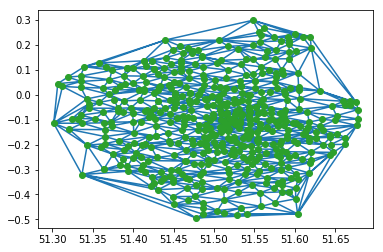

In [44]:
plt.triplot(coordinates_london.loc[:, 'Latitude'], coordinates_london.loc[:, 'Longitude'], tri.simplices.copy())
plt.plot(coordinates_london.loc[:, 'Latitude'], coordinates_london.loc[:, 'Longitude'], 'o')
plt.show()

In [45]:
%%time
try:
    with open('results_london.pkl', 'rb') as infile:
        results_london = pickle.load(infile)
        print('results of london loaded.')

except:
    results_london = [None for i in range(london_df.shape[0])]

    radius = london_dis_mean
    LIMIT = 200

    for location_id in tqdm(range(0, london_df.shape[0])):
        idd = location_id
        sp_name = london_df.loc[idd, 'Location']
        sp_la = london_df.loc[idd, 'Latitude']
        sp_lo = london_df.loc[idd, 'Longitude']

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(\
                                        CLIENT_ID, \
                                        CLIENT_SECRET, \
                                        sp_la, \
                                        sp_lo, \
                                        VERSION, \
                                        radius, \
                                        LIMIT)
        result = requests.get(url).json()
        results_london[location_id] = result
        #print(str(location_id) + ' is written')
    
    with open('results_london.pkl', 'wb') as outfile:
        pickle.dump(results_london, outfile)
        print('results of london scraped and saved.')

results of london loaded.
Wall time: 1.25 s


In [46]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [47]:
%%time

try:
    with open('venues_london.pkl', 'rb') as infile:
        venues_london = pickle.load(infile)
        print('venues of london loaded.')

except:
    venues_london = [None for i in range(london_df.shape[0])]

    for i in range(london_df.shape[0]):
        #print(i)
        if results_london[i]['response']:
            venues = results_london[i]['response']['groups'][0]['items']

            nearby_venues = json_normalize(venues) # flatten JSON

            # filter columns
            filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
            nearby_venues = nearby_venues.loc[:, filtered_columns]

            # filter the category for each row
            nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

            # clean columns
            nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

            #print(nearby_venues.shape)

            venues_london[i] = nearby_venues
    with open('venues_london.pkl', 'wb') as outfile:
        pickle.dump(venues_london, outfile)
        print('venues of london scraped and saved.')

venues of london loaded.
Wall time: 544 ms


In [48]:
venues_london_total = pd.concat(venues_london, axis=0)
venues_london_total.reset_index()
venues_london_total.shape

(36627, 4)

In [49]:
test_rg = np.random.choice(venues_london_total.shape[0], 1000, replace=False)
test_df = venues_london_total.iloc[test_rg, :]
test_df.head()

,name,categories,lat,lng
39,Brill,Coffee Shop,51.525767,-0.109477
18,PizzaExpress,Pizza Place,51.406065,0.016451
73,Tariro Fairtrade Coffee House,Coffee Shop,51.401712,-0.195487
38,Jun Ming Xuan,Chinese Restaurant,51.595409,-0.242935
24,The London Borough of Barking & Dagenham Stadium,Soccer Stadium,51.547615,0.160125


In [51]:
test1 = folium.Map(location=london_lon_lat, zoom_start=11, control_scale=True)

test_df = venues_london_total.iloc[test_rg, :]
for lat, lng, name, cat in zip(test_df['lat'], \
                                           test_df['lng'], \
                                           test_df['name'], \
                                           test_df['categories']):
    label = '{}, {}'.format(name, cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.3,
        parse_html=False).add_to(test1)  
    
test1

### Moscow Venues

In [52]:
coordinates_moscow = moscow_df[['Latitude', 'Longitude']]
tri = scipy.spatial.Delaunay(coordinates_moscow)

In [53]:
%%time
moscow_dis = []
for p0, p1, p2 in tri.simplices:
    d1 = ll_distance.distance(coordinates_moscow.loc[p0, :], 
                              coordinates_moscow.loc[p1, :]).km * 1000
    d2 = ll_distance.distance(coordinates_moscow.loc[p0, :], 
                              coordinates_moscow.loc[p2, :]).km * 1000
    d3 = ll_distance.distance(coordinates_moscow.loc[p1, :], 
                              coordinates_moscow.loc[p2, :]).km * 1000
    moscow_dis.extend([d1, d2, d3])
moscow_dis_mean = np.floor(np.mean(moscow_dis) / 600) * 600
print(moscow_dis_mean)

4200.0
Wall time: 491 ms


In [54]:
%%time
try:
    with open('results_moscow.pkl', 'rb') as infile:
        results_moscow = pickle.load(infile)
        print('results of moscow loaded.')

except:
    results_moscow = [None for i in range(moscow_df.shape[0])]

    radius = moscow_dis_mean
    LIMIT = 200

    for location_id in tqdm(range(0, moscow_df.shape[0])):
        idd = location_id
        sp_name = moscow_df.loc[idd, 'Location']
        sp_la = moscow_df.loc[idd, 'Latitude']
        sp_lo = moscow_df.loc[idd, 'Longitude']

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(\
                                        CLIENT_ID, \
                                        CLIENT_SECRET, \
                                        sp_la, \
                                        sp_lo, \
                                        VERSION, \
                                        radius, \
                                        LIMIT)
        result = requests.get(url).json()
        results_moscow[location_id] = result
        #print(str(location_id) + ' is written')
    print(str(location_id) + ' is written')
    with open('results_moscow.pkl', 'wb') as outfile:
        pickle.dump(results_moscow, outfile)
        print('results of moscow scraped and saved.')

results of moscow loaded.
Wall time: 555 ms


In [55]:
%%time
try:
    with open('venues_moscow.pkl', 'rb') as infile:
        venues_moscow = pickle.load(infile)
        print('venues of moscow loaded.')

except:
    venues_moscow = [None for i in range(moscow_df.shape[0])]

    for i in tqdm(range(moscow_df.shape[0])):
        if results_moscow[i]['response']:
            venues = results_moscow[i]['response']['groups'][0]['items']

            nearby_venues = json_normalize(venues) # flatten JSON

            # filter columns
            filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
            nearby_venues = nearby_venues.loc[:, filtered_columns]

            # filter the category for each row
            nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

            # clean columns
            nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

            #print(nearby_venues.shape)

            venues_moscow[i] = nearby_venues
        
    with open('venues_moscow.pkl', 'wb') as outfile:
        pickle.dump(venues_moscow, outfile)
        print('venues of moscow scraped and saved.')

venues of moscow loaded.
Wall time: 378 ms


### San Francisco Venues

In [56]:
coordinates_sanfra = sanfra_df[['Latitude', 'Longitude']]
tri = scipy.spatial.Delaunay(coordinates_sanfra)

In [57]:
%%time
sanfra_dis = []
for p0, p1, p2 in tri.simplices:
    d1 = ll_distance.distance(coordinates_sanfra.loc[p0, :], 
                              coordinates_sanfra.loc[p1, :]).km * 1000
    d2 = ll_distance.distance(coordinates_sanfra.loc[p0, :], 
                              coordinates_sanfra.loc[p2, :]).km * 1000
    d3 = ll_distance.distance(coordinates_sanfra.loc[p1, :], 
                              coordinates_sanfra.loc[p2, :]).km * 1000
    sanfra_dis.extend([d1, d2, d3])
sanfra_dis_mean = np.floor(np.mean(sanfra_dis) / 600) * 600
print(sanfra_dis_mean)

1200.0
Wall time: 312 ms


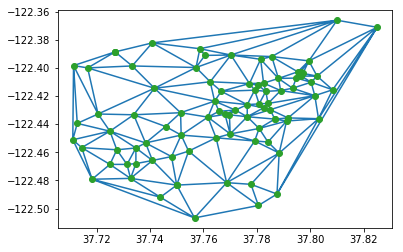

In [58]:
plt.triplot(coordinates_sanfra.loc[:, 'Latitude'], coordinates_sanfra.loc[:, 'Longitude'], tri.simplices.copy())
plt.plot(coordinates_sanfra.loc[:, 'Latitude'], coordinates_sanfra.loc[:, 'Longitude'], 'o')
plt.show()

In [59]:
%%time
try:
    with open('results_sanfra.pkl', 'rb') as infile:
        results_sanfra = pickle.load(infile)
        print('results of sanfra loaded.')
        
except:
    results_sanfra = [None for i in range(sanfra_df.shape[0])]

    radius = sanfra_dis_mean
    LIMIT = 200

    for location_id in tqdm(range(0, sanfra_df.shape[0])):
        idd = location_id
        sp_name = sanfra_df.loc[idd, 'Location']
        sp_la = sanfra_df.loc[idd, 'Latitude']
        sp_lo = sanfra_df.loc[idd, 'Longitude']

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(\
                                        CLIENT_ID, \
                                        CLIENT_SECRET, \
                                        sp_la, \
                                        sp_lo, \
                                        VERSION, \
                                        radius, \
                                        LIMIT)
        result = requests.get(url).json()
        results_sanfra[location_id] = result
        #print(str(location_id) + ' is written')
    print(str(location_id) + ' is written')
    with open('results_sanfra.pkl', 'wb') as outfile:
        pickle.dump(results_sanfra, outfile)
        print('results of sanfra scraped and saved.')

results of sanfra loaded.
Wall time: 795 ms


In [60]:
%%time
try:
    with open('venues_sanfra.pkl', 'rb') as infile:
        venues_sanfra = pickle.load(infile)
        print('venues of sanfra loaded.')

except:
    venues_sanfra = [None for i in range(sanfra_df.shape[0])]

    for i in tqdm(range(sanfra_df.shape[0])):
        if results_sanfra[i]['response']:
            venues = results_sanfra[i]['response']['groups'][0]['items']

            nearby_venues = json_normalize(venues) # flatten JSON

            # filter columns
            filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
            nearby_venues = nearby_venues.loc[:, filtered_columns]

            # filter the category for each row
            nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

            # clean columns
            nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

            print(nearby_venues.shape)

            venues_sanfra[i] = nearby_venues
        
    with open('venues_sanfra.pkl', 'wb') as outfile:
        pickle.dump(venues_sanfra, outfile)
        print('venues of sanfra scraped and saved.')

venues of sanfra loaded.
Wall time: 380 ms


Explanation